# Demo SEA data calculations
This demonstrates the use of low-level routines to replicate signal analysis performed by SEA.

Each analysis product is returned as a `xarray.DataArray`. At the end, they are merged into a single `xarray.Dataset` containing all of the different data results along with their labels, coordinates, and metadata.

### Generate fake data

In [1]:
from channel_analysis import waveform
from channel_analysis.structs import FilteredCapture
from iqwaveform import fourier
from channel_analysis import source
import numpy as np

import importlib

fourier = importlib.reload(fourier)

capture = FilteredCapture(sample_rate=15.36e6, analysis_bandwidth=10e6, duration=0.1)
iq = source.simulated_awgn(capture, xp=np)

### Channel power time-series

In [2]:
pvt = waveform.power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
).to_xarray()

In [3]:
%%timeit -n1 -r1

waveform.power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    detectors=('rms', 'peak'),
).to_xarray()

11.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


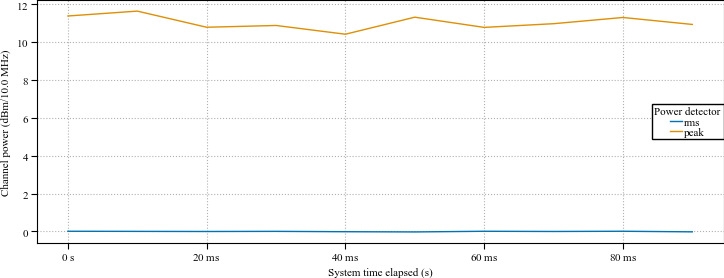

In [4]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from channel_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [5]:
cyclic_power = waveform.cyclic_channel_power(
    iq,
    capture,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

In [6]:
%%timeit -n1 -r1

cyclic_power = waveform.cyclic_channel_power(
    iq,
    capture,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

10.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


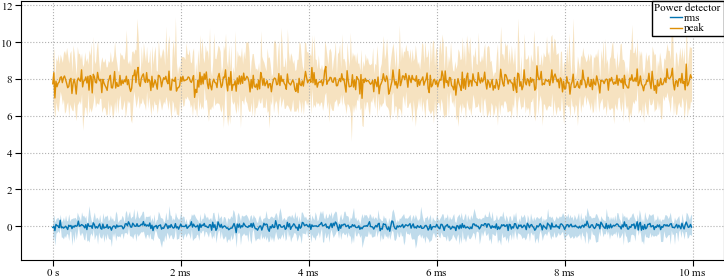

In [7]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, powtodB(a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        powtodB(a.sel(cyclic_statistic='min')),
        powtodB(a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Persistence Spectrum

In [8]:
frequency_resolution = 15e3
spectrum_quantiles = [0.5, 0.75, 0.95, 0.99, 1]

spectrum = waveform.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 5),
    resolution=frequency_resolution,
    statistics=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=False,
).to_xarray()

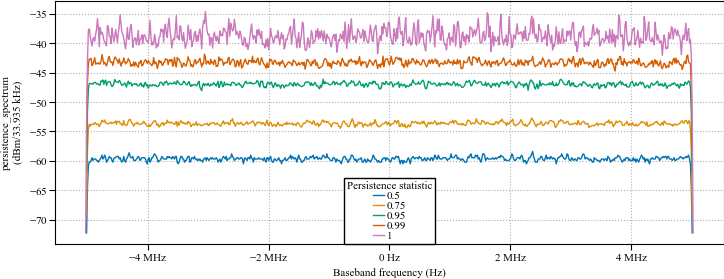

In [9]:
fig, ax = plt.subplots()

spectrum.pipe(powtodB).plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
# figures.label_legend(ax, spectrum, 'persistence_statistic')

In [10]:
%%timeit -n1 -r1 

spectrum = waveform.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 5),
    resolution=frequency_resolution,
    statistics=spectrum_quantiles,
    fractional_overlap=0.0,
    truncate=True,
).to_xarray()

45 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Amplitude Probability Distribution

In [11]:
apd_bins = dict(power_low=-60.0, power_high=15.0, power_count=55 * 4 + 1)

apd = waveform.amplitude_probability_distribution(iq, capture, **apd_bins).to_xarray()

In [12]:
%%timeit -n1 -r1

waveform.amplitude_probability_distribution(iq, capture, **apd_bins).to_xarray()

60.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


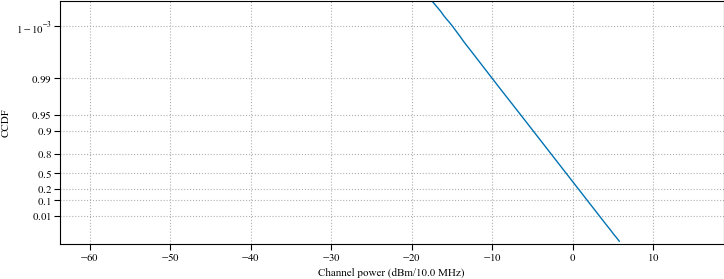

In [13]:
fig, ax = plt.subplots()
apd.plot(ax=ax)

ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

### Putting it all together

In [14]:
# %%timeit -n1 -r1

del iq

iq = source.simulated_awgn(capture, xp=np)
iq = source.filter_iq_capture(iq, capture)

analysis_spec = {
    'power_time_series': {'detector_period': 10e-3, 'detectors': ('rms', 'peak')},
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        # 'window': 'flattop',
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
        'resolution': 15e3,
        'statistics': [0.5, 0.75, 0.95, 0.99, 1],
        'truncate': True,
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
}

filter_spec = {
    'nfft': 1024,
    'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
}

result = waveform.analyze_by_spec(iq, capture, spec=analysis_spec)
result

<xarray.Dataset> Size: 26kB
Dimensions:                             (power_detector: 2, time_elapsed: 10,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         channel_power: 221,
                                         persistence_statistic: 5,
                                         baseband_frequency: 667)
Coordinates:
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * time_elapsed                        (time_elapsed) float64 80B 0.0 ... 0.09
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * persistence_statistic               (persistence_statistic) object 40B '0...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
Data variables:
    power_time_series                   (power_detector, time_elapsed) float16 40B ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float16 7kB ...
    amplitude_probability_distribution  (channel_power) float32 884B 1.0 ... 0.0
    persistence_spectrum                (persistence_statistic, baseband_frequency) float16 7kB ...
Attributes:
    analysis_bandwidth:  10000000.0
    analysis_filter:     {'nfft': 8192, 'window': 'hamming'}
    duration:            0.1
    sample_rate:         15360000.0

In [15]:
%%timeit -n1 -r1

waveform.analyze_by_spec(
    iq,
    capture,
    spec=analysis_spec,
)

108 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
from channel_analysis import io

io.dump('test.zarr.zip', result)

**path is  ''
kwargs:  {'path': ''}


In [20]:
result2 = io.load('test.zarr.zip')

kwargs:  {'synchronizer': None, 'path': None, 'storage_options': None}


array([[3.576e-07, 1.073e-06, 1.013e-06, ..., 1.132e-06, 8.941e-07,
        4.172e-07],
       [1.669e-06, 3.695e-06, 4.351e-06, ..., 4.232e-06, 3.994e-06,
        1.609e-06],
       [7.629e-06, 1.884e-05, 2.223e-05, ..., 1.812e-05, 1.997e-05,
        6.676e-06],
       [1.770e-05, 4.148e-05, 4.530e-05, ..., 4.584e-05, 4.274e-05,
        1.323e-05],
       [4.399e-05, 1.262e-04, 8.726e-05, ..., 1.245e-04, 1.845e-04,
        2.873e-05]], dtype=float16)